# DYNAMIC PROGRAMMING

In [1]:
import numpy as np
import Dynamic_Programming

The different functions used to do this are available in **Dynamic_Programming.py**.
- *OptimalBellmanValue* where we compute $V \mapsto \mathcal{T}V$
- *OptimalBellmanPolicy* where we compute the optimal policy $\pi(x) \in argmax_{a \in A}[r(x,a)+\gamma \sum_y p(y~|~x,a)V^{\pi}(x)]]$
- *PolicyEvaluation* where we compute the Value from any policy $\pi$
- *ValueIteratin* and *PolicyIteratoin*
- *PlotConvergenceValue* and *PlotConvergencePolicy* where we plot the convergence of $\|v^{k+1} - v^k\|_{\infty}$ using two different methods.

## Q1: Implement the discrete MDP model 

The reward matrix R such as: $R_{i,j} = r(s_j,a_i)$

The probability matrix P such as: $P[k]_{i,j} = p(s_j~|~s_i,a_k)$

In [2]:
R = np.array([[-0.4,0],[2,0],[-1,-0.5]])
P = np.array([
            [[0.45,0,0.55],[0,0,1],[0.6,0,0.4]]
            ,
            [[0,0,1],[0.5,0.4,0.1],[0,0.9,0.1]]
            ])
Actions = [0,1]
States = [0,1,2]

Model = Dynamic_Programming.MarkovDecisionProcess(States,Actions,P,R,0.95)

## Q2: Value Iteration

We implement and run value iteration (VI) in order to identify a 0.01-optimal policy. The stopping criterion is $\|v^{k+1} - v^k\| <\epsilon$ which implies $\|v^{d^+_{k+1}} − v^∗\|_{\infty} < \frac{2 \epsilon \gamma}{1 - \gamma}$ where $v^{d^+_{k+1}}$ is the greedy policy w.r.t $v^{k+1}$. Hence, we have: 
$\epsilon= 0.01\frac{1-\gamma}{2\gamma}$

In [3]:
V_0 = np.array([0, 0, 0])
V, Pi, i = Model.ValueIteratin(V_0)

In [4]:
print("The Value found after Value Iteration: ", V)

The Value found after Value Iteration:  [ 12.38870732  14.38870732  13.04099842]


In [5]:
print("The number of iterations needed to reach stopping criterion: ",i)

The number of iterations needed to reach stopping criterion:  155


### Plot $||v_k - v^*||_{\infty}$ as a function of iteration k

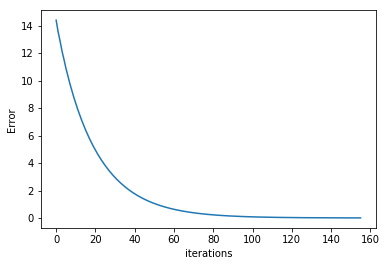

In [6]:
Pi_opt = np.array([1,0,1])
Model.PlotConvergenceValue(Pi_opt,V_0)

### The optimal policy

In [7]:
Pi = Model.OptimalBellmanPolicy(V)
Pi

array([1, 0, 1])

## Q2: Policy Iteration
We set the stopping criteria: $ V^{\pi_{k+1}} = V^{\pi_{k}} $  

In [8]:
Pi_0 = np.random.randint(Model.N_actions, size=Model.N_states)

In [9]:
Model.PolicyIteration(Pi_0)

array([1, 0, 1])

### Plot $||v_k - v^*||_{\infty}$ as a function of iteration k

ceci est V_1  [-5.66025289 -5.16947374 -5.43635364]
ceci est Pi_1  [1 0 1]
9


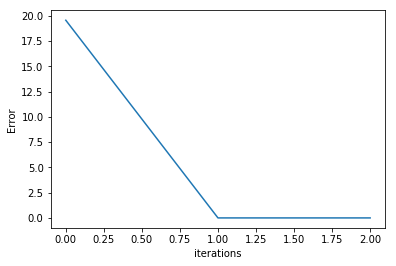

In [10]:
Pi_0 = np.random.randint(Model.N_actions, size=Model.N_states)
Model.PlotConvergencePolicy(Pi_opt,Pi_0)

We can see that Policy Iteration converges really fast compared to Value Iteration: 1 iteration for the first methode and more than a hundred for the second. Also, with PI, we will have absolute convergence since our stopping criterion is $V^{\pi_{k+1}} = V^{\pi_{k}}$ while convergence for VI is asymptotic.  
The complexities per iteration for the different methods are (with N=card(States) and M=card(Actions)):

-$O(N^{2.807})$ for Policy iteration (it is the cost of matrix inversion)

-$O(N^2M)$ for Value iteration

We can see that Policy Iteration is less consuming per iteration and since the total complexity for VI is $O(KN^2M)$ (with K the number of iterations). This explain our results. However, the matrix inversion and computations can be very consuming in big dimensions. 

In the note lectures (*notes-lectures-02*)
"
For Value Iteration:

**Pros:** each iteration is very computationally eﬃcient.

**Cons:** convergence is only asymptotic.

For Policy Iteration:

**Pros:** converge in a ﬁnite number of iterations (often small in practice).

**Cons:** each iteration requires a full policy evaluation and it might be expensive."

# REINFORCEMENT LEARNING

## Q4: Policy Evaluation

In [11]:
import numpy as np
import random 
from gridworld import GridWorld1
import matplotlib.pyplot as plt

In [12]:
env = GridWorld1
gamma  = 0.95
States = range(env.n_states)
Policy = [0 if 0 in env.state_actions[s] else 3 for s in States]
n_MC = 10000
T_max = 100
mu0 =(1/11)*np.ones(11)
V_opt = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 
         0.00000000, -0.82847001, -0.87691855,-0.93358351, -0.99447514]

The fonction **Trajectory** returns  the reward for a given trajectory (a given state, given, T_max and a policy). Also, since the reward is null except in the absorbing states, it would have been possible to only return the last reward. 

In [13]:
def Trajectory(state,action,T_max,policy):
    t = 1
    next_state, reward, term = env.step(state,action)
    gamma_r = (gamma**(t-1))*reward
    while((t<T_max) and not term):
        t+=1
        next_state, reward, term = env.step(next_state, policy[next_state])
        gamma_r += (gamma ** (t - 1)) * reward
    return gamma_r

### Computing $Q_{n}(x,a)$

In [14]:
N = np.zeros((env.n_states,len(env.action_names)))
Q = np.zeros((env.n_states,len(env.action_names)))
Error = []

In [15]:
for i in range(n_MC):
    Q_temp = np.zeros((env.n_states,len(env.action_names)))
    for s in States:
        for a in env.state_actions[s]:
            N[s,a]+=1
            Q[s,a]+=Trajectory(s,a,T_max,Policy)
    #Errors
    for i in range(env.n_states):
        for j in range(len(env.action_names)):
            if N[i, j] != 0:
                Q_temp[i, j] = Q[i, j] / N[i, j]
    V = [Q_temp[s][Policy[s]] for s in States]
    Error.append(sum(np.multiply(V,mu0))-sum(np.multiply(V_opt,mu0)))

### Plot $J^n − J^\pi$ as a function on n_MC

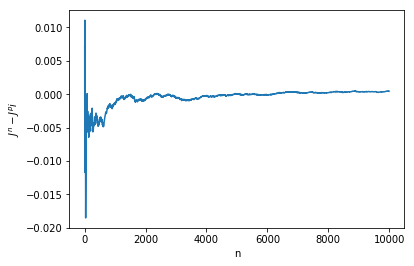

In [16]:
plt.plot(Error)
plt.xlabel("n")
plt.ylabel("$J^n - J^pi$")
plt.show()

We find a V similar to the value function computed with DP:

In [17]:
print(V)

[0.87724526652944823, 0.92826045988713302, 0.98860409449840458, 0.0, 0.67462270976618233, -0.99442153875000294, 0.0, -0.82801091232857016, -0.87670084234328693, -0.9339723292365919, -0.99425515000000164]


## Q5: Policy Optimization

We choose an $\alpha_{N(x_t,a_t)}$ satisfying  the usual stochastic approximation requirements (Robbins-Monro conditions): $\alpha_{N(x_t,a_t)} = \frac{1}{N(x_t,a_t)}$. We test different values of epsilon and 0.1 seems to be a satisfying one. 

In [18]:
V_opt = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 
         0.00000000, 0.77818504, 0.82369294,0.87691855, 0.82847001]

In [19]:
epsilon = 0.1
def EpsilonGreedyExplorationPolicy(Q,s):
    if random.random() < epsilon:
        return random.choice(env.state_actions[s])
    else:
        i = np.argmax(Q[s,env.state_actions[s]])
        return env.state_actions[s][i]

In [20]:
N = np.zeros((env.n_states,len(env.action_names)))
Q = np.zeros((env.n_states,len(env.action_names)))

Reward = []
Error = []

for i in range(n_MC):
    t= 0
    s = env.reset()
    term = False
    while((t<T_max) and not term):
        t += 1
        
        a = EpsilonGreedyExplorationPolicy(Q,s)
            
        next_s, rwrd, term = env.step(s,a)
        
        N[s,a]+=1
        alpha = 1/(N[s,a])
        Q[s,a] = (1-alpha)*Q[s,a]+alpha*(rwrd+gamma*np.max(Q[next_s,env.state_actions[next_s]]))
        s = next_s
        
    Reward.append(rwrd)    
    Error.append(sum(abs(V_opt-np.max(Q,axis=1))))

### Plot $||v^{\pi_n} - v^*||_{\infty}$ as a function of n

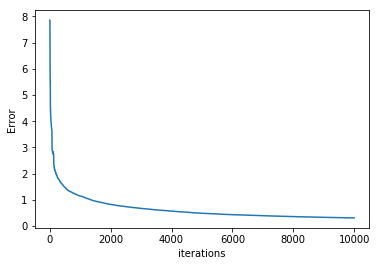

In [21]:
plt.plot(Error)
plt.xlabel("iterations")
plt.ylabel("Error")
plt.show()

### Plot Reward cumulated over an episode

In [22]:
Reward = np.cumsum(Reward)

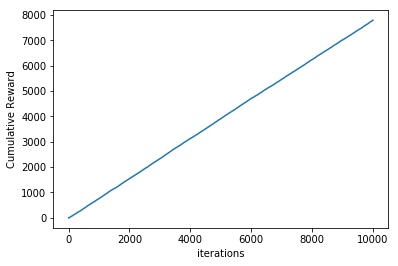

In [23]:
plt.plot(Reward)
plt.xlabel("iterations")
plt.ylabel("Cumulative Reward")
plt.show()

As excpected, the cumulative reward is an increasing function of the number of iterations.

### Optimal Policy

In [25]:
pi = [env.state_actions[s][np.argmax(Q[s][env.state_actions[s]])] for s in States]
pi

[0, 0, 0, 0, 3, 3, 0, 3, 0, 3, 2]

## Q5: Effect of initial Distribution:

There is no reason to have the same policy with different distributions. We can have a different policy (with the same Value) and it seems quite natural because one can see that two different "roads" can lead to the same result with same number of steps.

To confirm this, we run the policy optimization for different distributions until we have another policy.